# NLP BASIC

##Install Mecab & KoNLPy

In [ ]:
## 한국어 형태소 분석기로 토크나이징을 해야합니다. konlpy와 mecab을 먼저 설치해봅시다.
## 토크나이징을 해서 벡터화시킬 예정입니다.
!pip install konlpy
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

## Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
import re
import os
import gc
import time
import random
import string

import copy
from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
## Pytorch Import
import torch 
import torch.nn as nn

from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

## GPU 확인

In [ ]:
# 할당된 GPU 확인
!nvidia-smi

Mon Dec 12 06:46:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/rosp/Dacon/쇼핑몰 리뷰 평점 분류 경진대회/data/'

train = pd.read_csv(data_path + "train.csv")
test= pd.read_csv(data_path + "test.csv")
# ss = pd.read_csv(data_path + "sample_submission.csv")

In [ ]:
print("Train Shape: ", train.shape, "Test Shape: ", test.shape)
train.head()

Train Shape:  (25000, 3) Test Shape:  (25000, 2)


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [ ]:
train.target.unique()

array([2, 1, 5, 4])

## Target Categorical Encoding 

In [ ]:
train_encode = {v: k for k, v in enumerate(train.target.unique())}
train_encode                               

{2: 0, 1: 1, 5: 2, 4: 3}

In [ ]:
train_inverse = {v: k for k, v in train_encode.items()}
train_inverse

{0: 2, 1: 1, 2: 5, 3: 4}

In [ ]:
train['new_target'] = train.target.apply(lambda x: train_encode[x])
train.head()

,id,reviews,target,new_target
0,0,조아요 처음구입 싸게햇어요,2,0
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,0
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,0
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,2


## GETBOW and Preprocessing

In [ ]:
## Mecab을 사용해봅시다. 
from konlpy.tag import Mecab

mecab = Mecab() 

## Tokenizer and preprocessing

In [ ]:
# import re

predefined_pos = ["NNG", "NNP", "NNB", "NNBC", "NR", "NP",
                  "VV",
                  "VA", "VX", "VCP", "VCN",
                  "MM", "MAG", "MAJ"]

def text_pre(text, tokenizer = 'morphs'):
    # 1. Cleaning
    # 밑에 있는 cleaning 코드는 3개를 다 써도 되고, 일부만 사용해도 됩니다.
    #text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text) # 한국어 빼고 다 지우기
    text = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", "", text) # 특수문자 다 지우기
    #text = re.sub(["A-Za-z"], "", text) # 영어 다 지우기

    if tokenizer =='word':
        tokens = text.split()

    elif tokenizer =='nouns':
        tokens = mecab.nouns(text)

    elif tokenizer =='morphs':
        tokens = mecab.morphs(text)

    elif tokenizer =='predefined':

        tokens = []
        temp = mecab.pos(text)
        for token, pos in temp:
            if pos in predefined_pos:
                tokens.append(token)

    ## 3. Stop words
    SW = set()
    SW.add("불용어")

    result = [token for token in tokens if token not in SW]
    return result 


In [ ]:
sample = train.reviews.values[1]
sample

'생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 아깝네요'

In [ ]:
mecab.morphs(sample)

['생각',
 '보다',
 '잘',
 '안',
 '돼요',
 '매지',
 '바른',
 '지',
 '하루',
 '밖에',
 '안',
 '됐',
 '는데',
 'ㅠㅠ',
 '25',
 '천',
 '원',
 '가량',
 '주',
 '고',
 '사기',
 '너무',
 '아깝',
 '네요']

In [ ]:
mecab.nouns(sample)

['생각', '매지', '지', '하루', '천', '원', '가량', '사기']

### getbow

In [ ]:
def getbow(corpus):
    # corpus: [sentence1, sentence2,  ... ]

    bow = {'<BOS>': 1, '<EOS>': 2, '<PAD>':0}

    for sentence in corpus:
        for token in mecab.morphs(sentence):
            if token not in bow.keys():
                bow[token] = len(bow.keys())
    
    return bow

In [ ]:
train.reviews.to_list()[:2]

['조아요 처음구입 싸게햇어요', '생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 아깝네요']

In [ ]:
korbow = getbow(train.reviews.to_list())
len(korbow)

18343

In [ ]:
# korbow

### Let's find out max length

In [ ]:
max_length = 0
for idx in train.index:
    length = len(mecab.morphs(train.loc[idx, 'reviews']))
    if length > max_length:
        max_length = length

max_length

86

In [ ]:
# max_sl: 128 

## Prepare Loaders

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data = train, tokenizer = mecab.morphs, sl = 128):
        self.df = data
        self.sl = sl
        self.tokenizer = tokenizer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        ## index로 row 특정
        x = self.df.reviews[index] # 한 문장 -> "난 학교 간다."
        sentence = ['<BOS>'] + self.tokenizer(x)+ ['<EOS>']# ["난", "학교", 간-", "다"]
        sentence += ['<PAD>'] * (self.sl - len(sentence))
        x = np.array([korbow[token] for token in sentence])  
        x = torch.tensor(x, dtype = torch.long)

        y = self.df.new_target[index]
        y = torch.tensor(y, dtype = torch.long)

        return x, y

In [ ]:
index = 11
data = MyDataset()[index]
data[0]

tensor([  1, 187,  65,  29, 188, 189,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

In [ ]:
data[1]

tensor(0)

In [ ]:
def prepare_loaders(df = train, index_num = int(train.shape[0] * .7), bs = 64):
    # train, valid split
    train_df = df[:index_num].reset_index(drop = True)
    valid_df = df[index_num:].reset_index(drop = True)
    # train_ds, valid_ds
    train_ds = MyDataset(data = train_df)
    valid_ds = MyDataset(data = valid_df)
    # DataLoader
    train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, shuffle = False)
    print("DataLoader Completed")
    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = prepare_loaders()

DataLoader Completed


In [ ]:
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([64, 128]), torch.Size([64]))

# Model

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [ ]:
## nn.Embedding()
sample

'생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 아깝네요'

In [ ]:
sample_tensor = torch.tensor([korbow[token] for token in ['<BOS>'] + mecab.morphs(sample) + ['<EOS>'] + ['<PAD>']], dtype = torch.long).unsqueeze(0)
sample_tensor.shape # [1, sl]

torch.Size([1, 27])

In [ ]:
input_dim = len(korbow.keys())
hid_dim = 256
embed = nn.Embedding(input_dim, hid_dim)

In [ ]:
out = embed(sample_tensor)
out.shape

torch.Size([1, 27, 256])

In [ ]:
out[0, 0].shape

torch.Size([256])

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim = len(korbow.keys()), emb_dim = 256, 
                 sl = 128,  num_layers = 1, hidden_size = 512):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # x: [bs, sl]
        self.embed = nn.Embedding(input_dim, emb_dim) # [bs, sl] -> [bs, sl, emb_dim]

        # [bs, sl, emb_dim] -> [bs, sl, hidden_size]
        self.rnn = nn.RNN(input_size = emb_dim, 
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          batch_first = True,
                          bidirectional = False)
        # batch_first = True 일 때,
        # input_data's shape: [bs, sl, emb_dim(=input_size)]
        # input_h0's shape: [nl, bs, hidden_size] # nl: num_layers

        # output_data's shape: [bs, sl, hidden_size]
        # h_n's shape: [nl, bs, hidden_size] 
        # k = 
        self.seq = nn.Sequential( nn.Linear(k, 128), nn.ReLU(), nn.Linear(128, 4), nn.LogSoftmax(dim=-1) )

    def forward(self, x):
        # x: [bs, sl]
        x = self.embed(x) # [bs, sl] -> [bs, sl, emb_dim]

        bs = x.shape[0]

        h0 = torch.zeros(self.num_layers, bs, self.hidden_size) # [nl, bs, hidden_size] 
        output, h_n = self.rnn(x, h0)
        # output_data's shape: [bs, sl, hidden_size]
        # h_n's shape: [nl, bs, hidden_size] 



        

In [ ]:
# !pip install transformers

from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")

In [ ]:
text = "난이게정말뭐하는짓거린지..."

In [ ]:
text2 = " ".join(mecab.morphs(text))
text2

'난 이게 정말 뭐 하 는 짓 거린 지 . ..'

In [ ]:
tok.tokenize(text)

['난', '##이게', '##정말', '##뭐', '##하는짓', '##거', '##린지', '.', '.', '.']

In [ ]:
tok.tokenize(text2)

['난', '이게', '정말', '뭐', '하', '는', '짓', '거', '##린', '지', '.', '.', '.']

## Loss Function and Optimizer

In [ ]:
loss_fn = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

## Train_one_epoch

In [ ]:
# train_loss => 실시간 단위로 구할 예정
# accuracy => 실시간 단위로 구할 예정

from tqdm import tqdm
epoch = 1

def train_one_epoch(model = model, dataloader = train_loader, loss_fn = loss_fn, 
                    optimizer = optimizer, device = device, epoch = epoch):
    model.train()
    train_loss, dataset_size = 0,  0

    preds, trues = [], []

    bar = tqdm(dataloader, total = len(dataloader))
    for data in bar:
        x = data[0].to(device)    
        y_true = data[1].to(device) 
        y_pred = model(x)           
        y_pred = nn.LogSoftmax(dim = -1)(y_pred)
        loss = loss_fn(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = x.shape[0]
        dataset_size += bs 
        train_loss += (loss.item() * bs)
        train_epoch_loss = train_loss / dataset_size 

        preds.append(y_pred)
        trues.append(y_true) 

        preds_cat = torch.cat(preds, dim = 0) 
        trues_cat = torch.cat(trues, dim = 0) 

        train_acc = 100*(torch.argmax(preds_cat, dim =-1) == trues_cat).sum().item() / dataset_size
        bar.set_description(f"Epoch{epoch:02d}|TL:{train_epoch_loss:.3e}|ACCURACY:{train_acc:.2f}")

    return train_epoch_loss, train_acc


## Valid one epoch

In [ ]:
# train_loss => 실시간 단위로 구할 예정
# accuracy => 실시간 단위로 구할 예정

from tqdm import tqdm
epoch = 1

@torch.no_grad()
def valid_one_epoch(model = model, dataloader = valid_loader, loss_fn = loss_fn, 
                    device = device, epoch = epoch):
    model.eval()
    valid_loss, dataset_size = 0,  0

    preds, trues = [], []

    bar = tqdm(dataloader, total = len(dataloader))
    with torch.no_grad():
        for data in bar:
            x = data[0].to(device)      
            y_true = data[1].to(device) 
            y_pred = model(x)           
            y_pred = nn.LogSoftmax(dim = -1)(y_pred)
            loss = loss_fn(y_pred, y_true)

            bs = x.shape[0]
            dataset_size += bs 
            valid_loss += (loss.item() * bs)
            valid_epoch_loss = valid_loss / dataset_size 

            preds.append(y_pred) 
            trues.append(y_true) 

            preds_cat = torch.cat(preds, dim = 0)
            trues_cat = torch.cat(trues, dim = 0) 

            valid_acc = 100*(torch.argmax(preds_cat, dim =-1) == trues_cat).sum().item() / dataset_size
            bar.set_description(f"Epoch{epoch:02d}|VL:{valid_epoch_loss:.3e}|ACCURACY:{valid_acc:.2f}")

    return valid_epoch_loss, valid_acc


### Run Train

In [ ]:
def run_train(model = model, loss_fn = loss_fn, optimizer = optimizer, train_loader = train_loader, valid_loader = valid_loader):


    n_epochs = 25 
    print_iter =10

    lowest_loss, lowest_epoch = np.inf, np.inf
    early_stop = 30

    train_hs, valid_hs = [],  [] # visualization
    train_accs, valid_accs = [],  [] # visualization

    for epoch in range(n_epochs):
        train_loss, train_acc = train_one_epoch(model = model, dataloader = train_loader, loss_fn = loss_fn, optimizer = optimizer, 
                                      device = device, epoch = epoch)
        valid_loss, valid_acc = valid_one_epoch(model = model, dataloader = valid_loader, loss_fn = loss_fn, 
                                      device = device, epoch = epoch)
        # 줍줍
        train_hs.append(train_loss)
        valid_hs.append(valid_loss)

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        if (epoch + 1) % print_iter == 0:
            print()
            print(f"Ep:[{epoch + 1:02d}]|TL:{train_loss:.4e}|VL:{valid_loss:.4e}|LL:{lowest_loss:.4e}|")
            print()
        # Lowest Loss 갱신 - valid_loss 기준
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            # model 저장
            torch.save(model.state_dict(), './model.bin') # pt, pth 
        
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch + 1:
                print("넌 삽 질 중")
                break

    print()
    print("The Best Validation Loss=%.4e at %d Epoch" % (lowest_loss, lowest_epoch))

    # model load
    model.load_state_dict(torch.load('./model.bin'))


    result = dict()
    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs

    result["Train Acc"] = train_accs
    result["Valid Acc"] = valid_accs


    return result, model


In [ ]:
result, model = run_train()

### Visualization

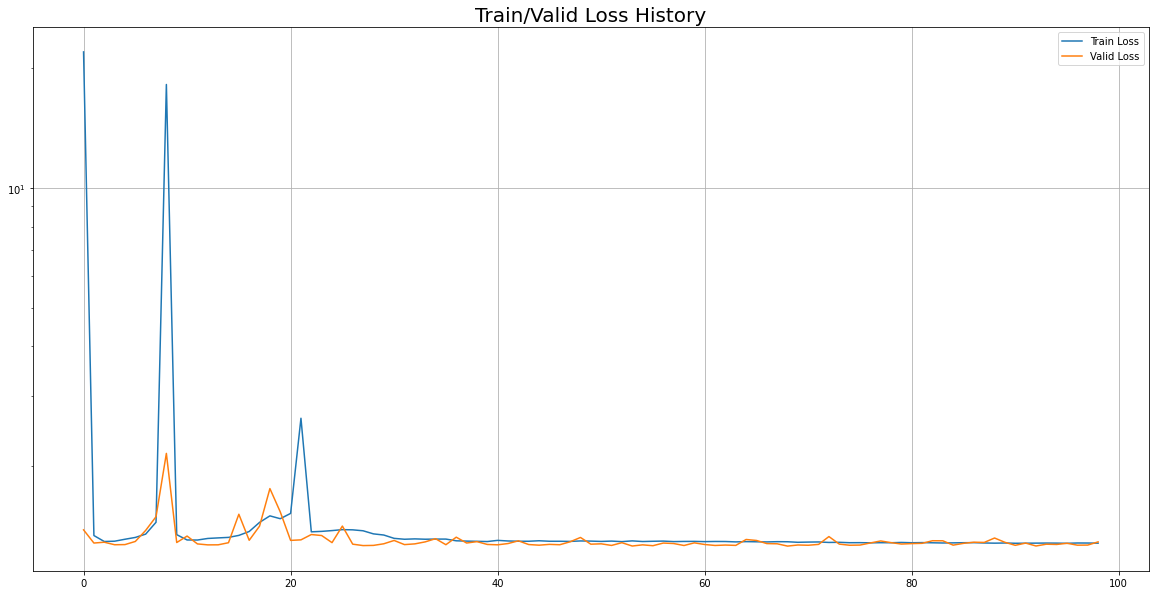

In [ ]:
## Train/Valid History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

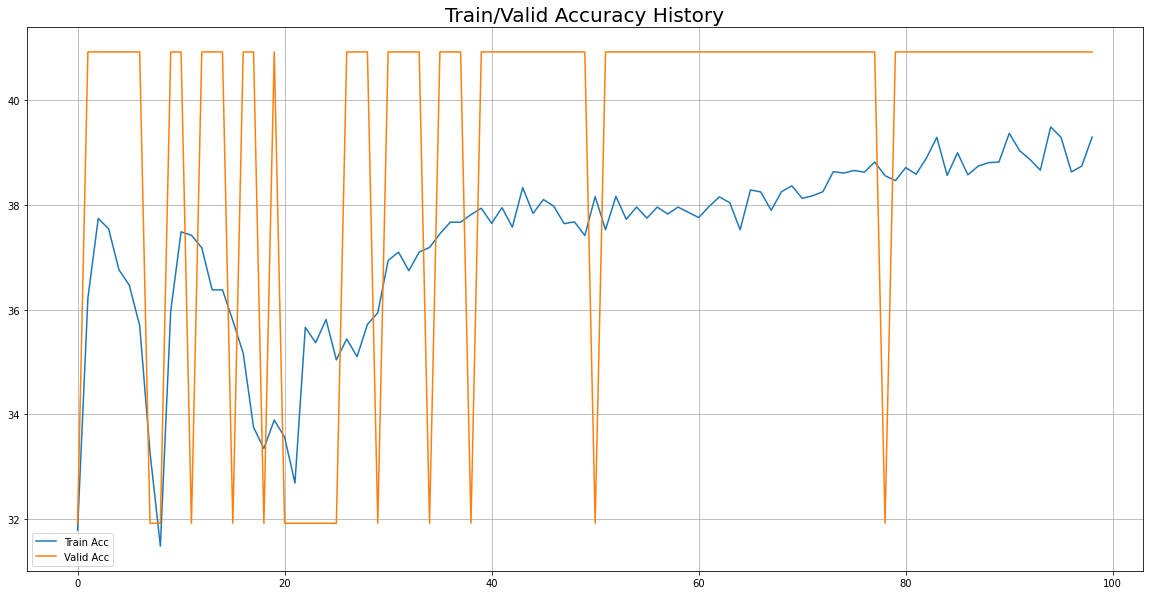

In [ ]:
# Train/Valid Accuracy
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Accuracy History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Acc'])), 
    result['Train Acc'], 
    label = 'Train Acc'
    )

plt.plot(
    range(0, len(result['Valid Acc'])), 
    result['Valid Acc'], 
    label = 'Valid Acc'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()